In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxr
from datetime import datetime, date
import json
from xgrads import open_CtlDataset
import geopandas as gpd
import requests
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import folium 
%matplotlib inline

In [10]:
# Choose a domain
domain = 'CHUK'

# Path to the SnowModel folder
SMpath = '/nfs/attic/dfh/2020_NPRB/domain_'+domain+'/snowmodel2023_cfsv2/'
# stream gage data 
gagepath = '/nfs/attic/dfh/2020_NPRB/data/stream_gage/'+domain+'/'
# ET data
etpath = '/nfs/attic/dfh/2020_NPRB/data/modis_ET/'+domain+'/'
# datapath
datapath = '/nfs/attic/dfh/2020_NPRB/data/SMinputs/'+domain+'/'
# prec ctl file
ctlFilePREC = SMpath+'ctl_files/wo_assim/prec_base.ctl'

#path to NPRB domains
domains_resp = requests.get("https://raw.githubusercontent.com/NPRB/02_preprocess_python/main/NPRB_domains.json")
domains = domains_resp.json()

# DATES
st_dt = '2011-10-01'
ed_dt = '2018-09-30'

In [3]:
# # open modified et file
# ctlFile = SMpath+'ctl_files/wo_assim/etx.ctl'

# et = open_CtlDataset(ctlFile)
# et

In [4]:
# # load ET data 
# # historical ET data - domain
# EThist_path = '/nfs/attic/dfh/2020_NPRB/data/climate_na_et/Normal_1991_2020_monthly/'+domain+'/historic_daily_et.nc'
# climatena = xr.open_dataset(EThist_path)
# #convert mm to m 
# et_m = climatena.et/1000
# # set all pixels to 0 where it is undefined in SM
# climatena['et_m'] = et_m
# climatena

In [5]:
# load station discharge data
path=gagepath+domain+'_discharge_cfs_'+st_dt+'_'+ed_dt+'.csv'
Q = pd.read_csv(path,parse_dates=['datetimeUTC'],infer_datetime_format=True,index_col='datetimeUTC')
Q

,USGS:15580095:00060:00003,USGS:15744500:00060:00003,USGS:15747000:00060:00003
datetimeUTC,,,
2011-10-01 00:00:00+00:00,NaN,13800.0,557.0
2011-10-02 00:00:00+00:00,NaN,13300.0,533.0
2011-10-03 00:00:00+00:00,NaN,12900.0,450.0
2011-10-04 00:00:00+00:00,NaN,12600.0,410.0
2011-10-05 00:00:00+00:00,NaN,12400.0,453.0
...,...,...,...
2018-09-26 00:00:00+00:00,1060.0,18100.0,797.0
2018-09-27 00:00:00+00:00,1020.0,17000.0,761.0
2018-09-28 00:00:00+00:00,981.0,15900.0,711.0


In [11]:
# load station metadata
path=gagepath+domain+'_gage_meta_proj_'+st_dt+'_'+ed_dt+'.geojson'
meta=gpd.read_file(path)
meta

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
0,USGS,15565700,UNALAKLEET R AB CHIROSKEY R NR UNALAKLEET AK,ST,635606.0,1601818.0,63.934297,-160.307472,M,S,...,None,NNNNNNNN,None,None,None,None,None,None,None,POINT (-308388.091 1566798.002)
1,USGS,15580095,NIUKLUK R AB MELSING C AT COUNCIL AK,ST,645331.0,1634012.0,64.891944,-163.670000,N,S,...,C,None,None,None,None,None,None,None,None,POINT (-456325.261 1692287.300)
2,USGS,15621000,SNAKE R NR NOME AK,ST,643351.0,1653026.0,64.563397,-165.509808,M,U,...,C,NNNNNNNN,None,None,None,None,None,None,None,POINT (-548664.359 1670023.966)
3,USGS,15744500,KOBUK R NR KIANA AK,ST,665825.0,1600751.0,66.972994,-160.133631,M,T,...,None,NYNNNNNN,None,None,None,None,None,None,None,POINT (-268698.713 1903009.388)
4,USGS,15746900,WULIK R AB FERRIC C NR KIVALINA AK,ST,680442.0,1631115.0,68.077675,-163.190455,M,T,...,None,NYNNNNNN,None,None,None,None,None,None,None,POINT (-385009.770 2039698.999)
5,USGS,15746980,IKALUKROK C AB RED DOG C NR KIVALINA AK,ST,680538.0,1625647.0,68.093236,-162.949346,M,U,...,None,NNNNNNNN,None,None,None,None,None,None,None,POINT (-374739.933 2040025.119)
6,USGS,15746988,NF RED DOG C NR KIVALINA AK,ST,680503.0,1625252.0,68.083515,-162.884066,M,U,...,None,NNNNNNNN,None,None,None,None,None,None,None,POINT (-372166.259 2038592.412)
7,USGS,15746990,RED DOG C AB MOUTH NR KIVALINA AK,ST,680522.0,1625622.0,68.088791,-162.942401,G,S,...,None,NYNNNNNN,None,None,None,None,None,None,None,POINT (-374516.875 2039498.785)
8,USGS,15746991,IKALUKROK C BL RED DOG C NR KIVALINA AK,ST,680251.0,1630134.0,68.046845,-163.029062,M,T,...,None,NYNNNNNN,None,None,None,None,None,None,None,POINT (-378752.998 2035392.305)
9,USGS,15747000,WULIK R BL TUTAK C NR KIVALINA AK,ST,675234.0,1634028.0,67.875440,-163.677373,M,T,...,None,NYNNNNNN,None,None,None,None,None,None,None,POINT (-408516.582 2020453.978)


In [7]:
# #only need to do this for BEAU
# # 10 largest stations 
# # sort stations by upslope area
# stnmeta = meta.sort_values('drain_area_va',ascending = False)
# # select 10 largest stations
# stnmeta = stnmeta[0:10]
# # sort stations by station id area
# stnmeta = stnmeta.sort_values('site_no')
# # reset index
# stnmeta = stnmeta.reset_index(drop=True)
# # new station list
# stn_list = stnmeta.site_no.tolist()
# stn_list
# stnmeta

In [8]:
# load upslope watershed area masks
upslope = xr.open_dataset(gagepath+'upslope.nc')
upslope

<xarray.Dataset>
Dimensions:      (y: 798, x: 763)
Coordinates:
    band         int64 ...
  * y            (y) float64 2.158e+06 2.158e+06 ... 1.362e+06 1.362e+06
  * x            (x) float64 -7.435e+05 -7.425e+05 ... 1.75e+04 1.85e+04
    spatial_ref  int64 ...
Data variables:
    15565700     (y, x) float32 ...
    15580095     (y, x) float32 ...
    15621000     (y, x) float32 ...
    15744500     (y, x) float32 ...
    15746900     (y, x) float32 ...
    15746980     (y, x) float32 ...
    15746990     (y, x) float32 ...
    15746991     (y, x) float32 ...
    15747000     (y, x) float32 ...

In [9]:
# station data 
gagepath = '/nfs/attic/dfh/2020_NPRB/data/stream_gage/'+domain+'/'
# all domains have the same start date
st_dt = '2011-10-01'
ed_dt = '2018-09-30'

stn = gpd.read_file(gagepath+domain+'_gage_meta_proj_'+st_dt+'_'+ed_dt+'.geojson')

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

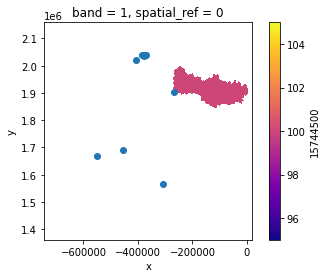

In [10]:
fig, ax = plt.subplots()
upslope['15744500'].plot(ax=ax,cmap='plasma')
stn.plot(ax=ax)


In [11]:
# a step before this notebook in QGIS:
# determine which watershed will be used to calculate the prec cf
#BEAU
stn_list = ['15744500','15747000']

### calculate weighted precip correction factor

In [12]:
# start_years_list = list(range(2001,2018))
# end_years_list = list(range(2003,2020))
start_years_list = list(range(int(st_dt[:4])+1,int(ed_dt[:4])))
end_years_list = list(range(int(st_dt[:4])+2,int(ed_dt[:4])+1))



specPs = np.empty([len(start_years_list),len(stn_list)])
specQs = np.empty([len(start_years_list),len(stn_list)])
specETs = np.empty([len(start_years_list),len(stn_list)])
Pcfs = np.empty([len(start_years_list),len(stn_list)])
numpixs = []

# prec data
P = open_CtlDataset(ctlFilePREC)
# P = P.rename({'lon': 'x', 'lat': 'y'})

# open modified et file
ctlFile = SMpath+'ctl_files/wo_assim/etx.ctl'
ET = open_CtlDataset(ctlFile)

for g in range(len(stn_list)):
    gage = stn_list[g]
    print(gage)
    #calculate number of pixels in upslope
    numpix = int(upslope[gage].where(upslope[gage]==100).count())
    numpixs.append(numpix)
    #         # calculate upslpe area
    #         wshedA=numpix*1000*1000
    # watershed area area
    wshedA=meta.drain_area_va[meta.site_no==gage].values[0]*2.59e6
    #print('ratio',wshedA/(numpix*1000*1000))
    for y in range(len(start_years_list)):
        styr = start_years_list[y]
        edyr = end_years_list[y]
        print('wy = ',edyr)

        # station name
        stn = 'USGS:'+gage+':00060:00003'
        # stn Q
        stnQ = Q[stn][str(styr)+'-10-01' :str(edyr)+'-09-30']
        if len(stnQ[stnQ.isnull()])/len(stnQ)>.1:
            print('missing more than 10% of days')
            specPs[y,g]=np.nan
            specQs[y,g]=np.nan
            specETs[y,g]=np.nan
            Pcfs[y,g]=np.nan
            continue
        else:
            # convert stn units of cfs to m^3/d
            stnq = stnQ*60*60*24/35.3147
            # prec data
            p = P.sel(time=slice(str(styr)+'-10-01',str(edyr)+'-09-30'))
            #add upslope mask
            p['mask'] = (['lat', 'lon'],  np.flipud(upslope[gage].values))
            # specific precipitation
            psum = p.prec.sum(dim='time')
            specP=np.nansum(psum.where((p.mask==100)&(psum>0)).values)/numpix
            specPs[y,g]=specP
            #et data
            et = ET.sel(time=slice(str(styr)+'-10-01',str(edyr)+'-09-30'))
            #add upslope mask
            et['mask'] = (['lat', 'lon'],  np.flipud(upslope[gage].values))
            # specific precipitation
            etsum = et.etx.sum(dim='time')
            specET=np.nansum(etsum.where((et.mask==100)&(etsum>0)).values)/numpix
            specETs[y,g]=specET
            # specific discharge 
            specQ=stnq.sum()/wshedA
            specQs[y,g]=specQ
            # # specific ET
            # et_tot = climatena.et_m.sum(dim='time')
            # specET = et_tot.where(climatena.mask==1).sum().values/numpix
            # specETs[y,g]=specET
            # correction factor 
            Pcfs[y,g]=(specQ+specET)/specP
            # Pcfs[y,g]=specQ/specP
            print('specP',specP)
            print('specQ',specQ)
            print('specET',specET)


15744500
wy =  2013
missing more than 10% of days
wy =  2014
missing more than 10% of days
wy =  2015
specP 0.5464987936350684
specQ 0.47556879091120596
specET 0.12317359245249677
wy =  2016
specP 0.6066145010073912
specQ 0.49617213177279773
specET 0.13822661920054322
wy =  2017
specP 0.5989461873580747
specQ 0.5830485393609195
specET 0.1484398806401387
wy =  2018
specP 0.6868537268606126
specQ 0.7165004346190378
specET 0.15816228452054298
15747000
wy =  2013
specP 0.7054125197390293
specQ 0.5963303702940665
specET 0.16193324961560837
wy =  2014
specP 0.7638342025432181
specQ 0.5738772875630898
specET 0.14229177019556646
wy =  2015
specP 0.6605712313460402
specQ 0.4280641486423492
specET 0.12765317154832484
wy =  2016
specP 0.5284065625346299
specQ 0.31704946926641414
specET 0.11866210143898677
wy =  2017
specP 0.62345428106069
specQ 0.4940035951604938
specET 0.15751503658069224
wy =  2018
specP 0.6979979025838505
specQ 0.6231209468735353
specET 0.14072746475255798


In [8]:
# 15744500
# specific discharge based on stream stats
drainageAmi=9480
drainageAkm = drainageAmi*2.59
drainageAm = drainageAkm*1e6
MAP = 18/39.37 #in to m 
Qdaily_cfs = 15250.436 #[cfs]
Qdaily_cms = Qdaily_cfs/35.3147
specq = Qdaily_cms*60*60*24*365/drainageAm
MAP,specq,specq/MAP

(0.4572009144018288, 0.5546579527325022, 1.2131601999488117)

In [7]:
# 15747000
# specific discharge based on stream stats
drainageAmi=705
drainageAkm = drainageAmi*2.59
drainageAm = drainageAkm*1e6
MAP = 14/39.37 #in to m 
Qdaily_cfs = 1017.441 #[cfs]
Qdaily_cms = Qdaily_cfs/35.3147
specq = Qdaily_cms*60*60*24*365/drainageAm
MAP,specq,specq/MAP

(0.35560071120142245, 0.49758976545371153, 1.3992935047080444)

In [14]:
# dataframe of stations with correction factors for each year
df = pd.DataFrame(Pcfs,columns = stn_list)
df

,15744500,15747000
0,NaN,1.074922
1,NaN,0.937598
2,1.095597,0.841268
3,1.045802,0.824576
4,1.221292,1.045014
5,1.273434,1.094342


In [15]:
# data frame with mean cfs and weight
newdf = pd.DataFrame(list(zip(stn_list,df.median().values,numpixs)),columns=['stn','cf','numpix'])
# drop stations with nan cf
newdf=newdf[~newdf.cf.isnull()]
newdf['wt']= newdf.numpix/newdf.numpix.sum()
newdf

,stn,cf,numpix,wt
0,15744500,1.158445,22459,0.929941
1,15747000,0.991306,1692,0.070059


In [16]:
newdf.to_csv(datapath + domain+'_precCF_'+st_dt+'_'+ed_dt+'_cfsv2.csv')

In [17]:
# calculate weighted correction factor
np.nansum(newdf.cf*newdf.wt)

1.1467350357171058

### calc cf for largest watershed

In [44]:
#find station with the largest upslope area
stn_list = meta.site_no.tolist()
count = []
for stn in stn_list:
    count.append(upslope[stn].where(upslope[stn]==100).count().values.tolist())
    
gage = np.array(stn_list)[count==np.max(count)][0]
gage

'15744500'

In [45]:
# et data 
modis['mask'] = upslope[gage]
modis

<xarray.Dataset>
Dimensions:      (wy: 18, y: 798, x: 763)
Coordinates:
  * wy           (wy) int64 2002 2003 2004 2005 2006 ... 2016 2017 2018 2019
  * y            (y) float64 2.158e+06 2.158e+06 ... 1.362e+06 1.362e+06
  * x            (x) float64 -7.435e+05 -7.425e+05 ... 1.75e+04 1.85e+04
    band         int64 1
    spatial_ref  int64 0
Data variables:
    modisET      (wy, y, x) float64 ...
    mask         (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [46]:
#calculate number of pixels in upslope
numpix = int(modis.mask.where(modis.mask==100).count())
# calculate upslpe area
wshedA=int(modis.mask.where(modis.mask==100).count())*1000*1000
numpix,wshedA

(22459, 22459000000)

In [47]:
start_years_list = list(range(int(st_dt[:4]),int(ed_dt[:4])))
end_years_list = list(range(int(st_dt[:4])+1,int(ed_dt[:4])+1))

specPs = []
specQs = []
specETs = []
Pcfs = []

for y in range(len(start_years_list)):
    styr = start_years_list[y]
    edyr = end_years_list[y]
    print(edyr)

    # station name
    stn = stn = 'USGS:'+gage+':00060:00003'
    # stn Q
    stnQ = Q[stn][str(styr+1)+'-09-01' :str(edyr)+'-08-31']
    # convert stn units of cfs to m^3/d
    stnq = stnQ*60*60*24/35.3147
    # prec data
    p = open_CtlDataset(ctlFilePREC)
    #add upslope mask
    p['mask']=(['lat', 'lon'],  np.flipud(upslope[gage].values))
    # specific precipitation
    specP=np.nansum(p.prec.sum(dim='time').where(p.mask==100).values)/numpix
    specPs.append(specP)
    # specific discharge 
    specQ=stnq.sum()/wshedA
    specQs.append(specQ)
    # specific ET
    specET = np.nansum(modis.modisET.sel(wy = edyr).where(modis.mask==100).values)/numpix
    specETs.append(specET)
    # correction factor 
    Pcfs.append(specP/(specQ+specET))

2010
2011
2012
2013
2014


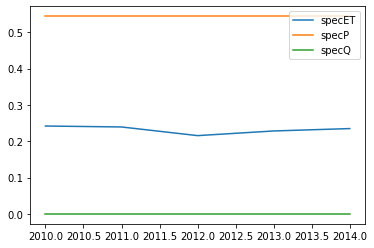

In [48]:
plt.plot(end_years_list,specETs,label ='specET')
plt.plot(end_years_list,specPs,label ='specP')
plt.plot(end_years_list,specQs,label ='specQ')
plt.legend()

In [49]:
# save correction factors 
df = pd.DataFrame(list(zip(end_years_list,Pcfs)),columns = ['wy','cf'])
df

,wy,cf
0,2010,2.248797
1,2011,2.273335
2,2012,2.524710
3,2013,2.382887
4,2014,2.316220


(2.3491896778308075, 2.3162199086237214)

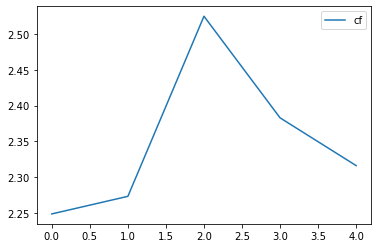

In [50]:
df.cf.plot(label = 'cf',legend=True)
df.cf.mean(),df.cf.median()

In [51]:
df.to_csv(datapath+'prec_cf_wy'+st_dt[:4]+'_'+ed_dt[:4]+'.csv')